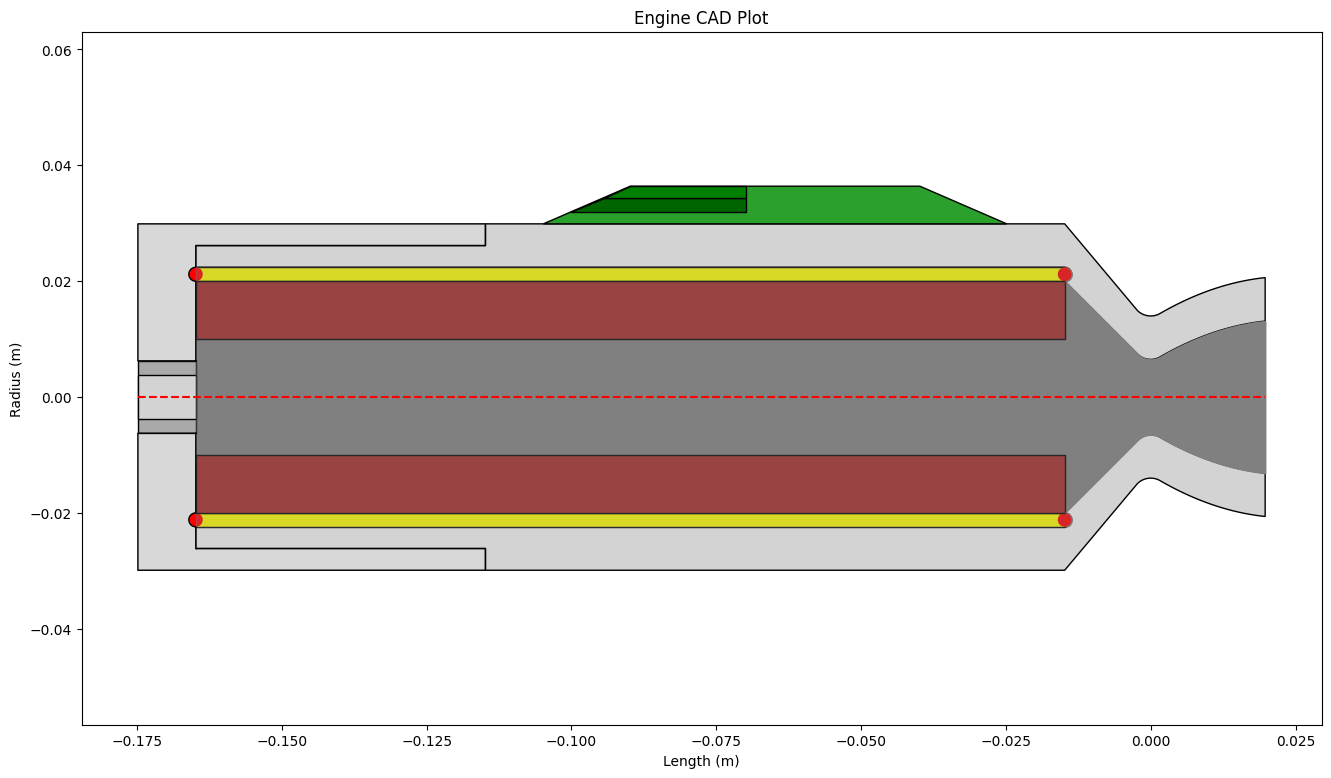

In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import sympy as sp
import csv

nozz = 'BN1.json'

def get_data(type, file):
        with open('temp_dir.txt', 'r') as txt:
            dir = txt.readline()
        file_path = dir + f'\\{type}\\' + file
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data

class EngineCADBuilder_ConventionalNozzle:
    def __init__(self, nozzle):
        self.nozzleData = get_data(type='Nozzles', file=nozzle)
        self.engineUsed = self.nozzleData["Inputs"]["EngineConfig"]
        self.engineData = get_data(type='Engines', file=self.engineUsed)

        self.LComb = self.engineData["Lc"]
        self.LNozz = self.nozzleData["calculatedResults"]["Longitud (m)"]

        self.nozzle_X = np.array(self.nozzleData["geometry_data"]["X (m)"])
        self.nozzle_Y = np.array(self.nozzleData["geometry_data"]["Y (m)"])

        self.rThroat = self.nozzleData["calculatedResults"]["Rt (m)"]
        self.rExit = self.nozzleData["calculatedResults"]["R2 (m)"]
    
    
    def create_arc(self, x_center, y_center, theta_1, theta_2 ,radius, num_points=100, turn=1):
        angles = np.linspace(theta_1, theta_2, num_points)
        x_arc = x_center + radius * np.cos(angles) * turn
        y_arc = y_center + radius * np.sin(angles)
        return x_arc, y_arc
    
    def remove_duplicate_points(self, x, y):
        points = np.vstack((x, y)).T
        unique_points = np.unique(points, axis=0)
        return unique_points[:, 0], unique_points[:, 1]
    
    def convergent_throat(self, user_settings, offset=0):
        K1 = user_settings['KIn']
        Rt = self.rThroat
        alpha = user_settings["alpha"] * np.pi / 2
        th = np.linspace(-np.pi / 2, -np.pi / 2 - alpha, user_settings["n_conv"])
        x = K1 * Rt * np.cos(th)
        y = K1 * Rt * np.sin(th) + K1 * Rt + Rt + offset
        return x, y
    
    def convergent_cone(self, user_settings, offset=0):
        RCartucho = self.engineData["Re"] + user_settings["t_cartridge"]
        alpha = user_settings["alpha"] * np.pi / 2
        dx = (RCartucho - self.y3) / np.tan(alpha)
        dx_p = user_settings["t_cartridge"] / np.tan(alpha)
        x = self.x3 - dx + dx_p
        y = self.engineData["Re"]
        return x, y 

    def find_tangent_points(self, Px, Py, r):
        # Definir las variables
        x, y = sp.symbols('x y')
        d = np.sqrt(Px**2 + Py**2)
        
        # Definir las ecuaciones de las circunferencias
        aux_circ1 = (x - Px)**2 + (y - Py)**2 - d**2
        aux_circ2 = x**2 + y**2 - d**2
        
        # Resolver el sistema de ecuaciones
        aux_intersecs = sp.solve([aux_circ1, aux_circ2], (x, y))
        if not aux_intersecs:
            raise ValueError("No se encontraron puntos de intersección.")
        
        x1, y1 = aux_intersecs[0]
        x2, y2 = aux_intersecs[1]
        
        # Encontrar la pendiente de la recta tangente
        m = (y1 - y2) / (x1 - x2)
        # Ecuación de la recta tangente en forma punto-pendiente
        n = y1 - m * x1
        f = m * x + n - y
        
        # Definir la circunferencia final con centro en (Px/2, Py/2) y radio d/2
        finalCirc = (x - Px/2)**2 + (y - Py/2)**2 - (d/2)**2
        rocketCirc = x**2 + y**2 - r**2
        # Resolver para encontrar los puntos tangentes
        tan_intersecs = sp.solve([rocketCirc, finalCirc], (x, y))
        if not tan_intersecs:
            raise ValueError("No se encontraron puntos tangentes.")
        
        tan_point = max(tan_intersecs, key=lambda par: par[0])
        
        return float(tan_point[0]), float(tan_point[1])
    



    def sketchEngine(self, user_settings):
        nozzle_x_in, nozzle_y_in = np.flip(self.nozzle_X), np.flip(self.nozzle_Y)
        nozzle_x_wall, nozzle_y_wall = np.flip(self.nozzle_X), np.flip(self.nozzle_Y) + user_settings["wall_t"]

        convergent_x, convergent_y = self.convergent_throat(user_settings)
        convergent_x_wall, convergent_y_wall = self.convergent_throat(user_settings, user_settings["wall_t"])

        self.x1, self.y1 = nozzle_x_in[0], nozzle_y_in[0]
        self.x2, self.y2 = nozzle_x_in[-1], nozzle_y_in[-1]
        self.x3, self.y3 = convergent_x[-1], convergent_y[-1]
        self.x4, self.y4 = self.convergent_cone(user_settings)
        self.x5, self.y5 = self.x4, self.y4 + user_settings["t_cartridge"]
        self.x6, self.y6 = self.x5 - self.LComb, self.y5
        self.x7, self.y7 = self.x6, self.y6 + user_settings["wall_t"] * user_settings["hBoltFactor"]
        self.x8, self.y8 = self.x7 + user_settings["bolt_OffSet"], self.y7
        self.x9, self.y9 = self.x8, self.y6 + user_settings["wall_t"]
        self.x10, self.y10 = self.x5, self.y9
        self.x11, self.y11 = self.x3, self.y3 + user_settings["wall_t"]
        self.x12, self.y12 = self.x2, self.y2 + user_settings["wall_t"]
        self.x13, self.y13 = self.x1, self.y1 + user_settings["wall_t"]
        
        self.radi = user_settings["t_cartridge"]/2
        ring_arc_x, ring_arc_y = self.create_arc(self.x4, self.y4 + self.radi, -np.pi/2, np.pi/2 ,self.radi)

        self.x1c, self.y1c = self.x6, user_settings["r_elect"] + user_settings["d_elect"]/2
        self.x2c, self.y2c = self.x1c, self.y7
        self.x3c, self.y3c = self.x8, self.y8
        self.x4c, self.y4c = self.x9, self.y9
        self.x5c, self.y5c = self.x6 - user_settings["cover_t"], self.y9
        self.x6c, self.y6c = self.x5c, self.y1c

        self.x0c, self.y0c = self.x1c, self.y4 + self.radi
        self.x01c, self.y01c = self.x1c, self.y4
        self.x02c, self.y02c = self.x1c, self.y5

        fullTHeight = self.y10 + user_settings["upper_offset"] + user_settings["lower_offset"] + user_settings["T_height"]
        medTHeight = self.y10 + user_settings["lower_offset"] + user_settings["T_height"]
        lowTHeight = self.y10 + user_settings["lower_offset"]

        self.x1m, self.y1m = user_settings["T_Re"], fullTHeight
        self.x2m, self.y2m = user_settings["T_Ri"], fullTHeight
        self.x3m, self.y3m = user_settings["T_Ri"], medTHeight
        self.x4m, self.y4m = user_settings["T_Re"], medTHeight
        self.x5m, self.y5m = user_settings["T_Re"], lowTHeight
        self.x6m, self.y6m = - user_settings["T_Re"], lowTHeight
        self.x7m, self.y7m = - user_settings["T_Re"], medTHeight
        self.x8m, self.y8m = - user_settings["T_Ri"], medTHeight
        self.x9m, self.y9m = - user_settings["T_Ri"], fullTHeight
        self.x10m, self.y10m = - user_settings["T_Re"], fullTHeight

        available_len = self.x10 - self.x9
        low_offset = (available_len - user_settings["mount_low_len"])/2
        high_offset = (available_len - user_settings["mount_high_len"])/2

        self.x1me, self.y1me = self.x9 + low_offset, self.y10
        self.x2me, self.y2me = self.x9 + high_offset, self.y1m
        self.x3me, self.y3me = self.x10 - high_offset, self.y1m
        self.x4me, self.y4me = self.x10 - low_offset, self.y10

        if user_settings["type"] == 'Fitted':

            nozzleBodyWall_x = np.concatenate((
                [self.x10, self.x11],
                np.flip(convergent_x_wall),
                np.flip(nozzle_x_wall),
                [self.x13,self.x1]
            ))

            nozzleBodyWall_y = np.concatenate((
                [self.y10, self.y11],
                np.flip(convergent_y_wall),
                np.flip(nozzle_y_wall),
                [self.y13,self.y1]
            ))

        elif user_settings["type"] == 'Bulk':

            nozzleBodyWall_x = np.concatenate((
                [self.x10, self.x13],
                [self.x13, self.x1]
            ))

            nozzleBodyWall_y = np.concatenate((
                [self.y10, self.y13],
                [self.y13, self.y1]
            ))



        engine_sketch_x = np.concatenate([
            nozzle_x_in,
            convergent_x,
            [self.x3, self.x4],
            [self.x4, self.x5] if not user_settings["oring"] else ring_arc_x,
            [self.x5, self.x6],
            [self.x6, self.x7],
            [self.x7, self.x8],
            [self.x8, self.x9],
            [self.x9, self.x10],
            nozzleBodyWall_x,
        ])

        engine_sketch_y = np.concatenate([
            nozzle_y_in,
            convergent_y,
            [self.y3, self.y4],
            [self.y4, self.y5] if not user_settings["oring"] else ring_arc_y,
            [self.y5, self.y6],
            [self.y6, self.y7],
            [self.y7, self.y8],
            [self.y8, self.y9],
            [self.y9, self.y10],
            nozzleBodyWall_y
        ])

        return engine_sketch_x, engine_sketch_y
    
    def sketchCartridge(self, axes, user_settings):
        t_cartridge = user_settings["t_cartridge"]
        x = self.x6
        yUp = self.engineData["Re"]
        yDown = -yUp - t_cartridge
        cartridge_up = patches.Rectangle((x, yUp), self.LComb, t_cartridge, edgecolor='k', facecolor='yellow')
        cartridge_down = patches.Rectangle((x, yDown), self.LComb, t_cartridge, edgecolor='k', facecolor='yellow')
        axes.add_patch(cartridge_up)
        axes.add_patch(cartridge_down)

    def sketchRing_Engine(self, axes, user_settings):
        t_cartridge = user_settings["t_cartridge"]
        x = self.x4
        yUp = self.y4 + t_cartridge/2
        yDown = -yUp
        oring_up = patches.Circle((x, yUp), t_cartridge/2, facecolor='r')
        oring_down = patches.Circle((x, yDown), t_cartridge/2, facecolor='r')
        axes.add_patch(oring_up)
        axes.add_patch(oring_down)

    def sketchRing_Cover(self, axes, user_settings):
        t_cartridge = user_settings["t_cartridge"]
        x = self.x0c
        yUp = self.y0c
        yDown = -yUp
        oring_up = patches.Circle((x, yUp), t_cartridge/2, facecolor='r')
        oring_down = patches.Circle((x, yDown), t_cartridge/2, facecolor='r')
        axes.add_patch(oring_up)
        axes.add_patch(oring_down)

    def sketchPropellant(self, axes, user_settings):
        propellant_thickness = self.engineData["Re"] - self.engineData["Ri"]
        x = self.x6 
        yUp = self.engineData["Ri"]
        yDown = -self.engineData["Re"]
        propellant_up = patches.Rectangle((x, yUp), self.LComb, propellant_thickness, edgecolor='k', facecolor='brown')
        propellant_down = patches.Rectangle((x, yDown), self.LComb, propellant_thickness, edgecolor='k', facecolor='brown')
        axes.add_patch(propellant_up)
        axes.add_patch(propellant_down)

    def sketchCover(self, axes, user_settings):
        arc_x, arc_y = self.create_arc(self.x0c, self.y0c, -np.pi/2, np.pi/2 , self.radi, turn=-1)

        w = user_settings["cover_t"]
        h = user_settings["r_elect"] - user_settings["d_elect"]/2

        w_b = w
        h_b = user_settings["r_elect"] + user_settings["d_elect"]/2

        if not user_settings["cring"]:

            cover_x = np.concatenate((
                [self.x1c, self.x2c],
                [self.x2c, self.x3c],
                [self.x3c, self.x4c],
                [self.x4c, self.x5c],
                [self.x5c, self.x6c],
                [self.x6c, self.x1c],
            ))

            cover_y = np.concatenate((
                [self.y1c, self.y2c],
                [self.y2c, self.y3c],
                [self.y3c, self.y4c],
                [self.y4c, self.y5c],
                [self.y5c, self.y6c],
                [self.y6c, self.y1c],
            ))

        else:

            cover_x = np.concatenate((
                [self.x1c, self.x01c],
                arc_x,
                [self.x02c, self.x2c],
                [self.x2c, self.x3c],
                [self.x3c, self.x4c],
                [self.x4c, self.x5c],
                [self.x5c, self.x6c],
                [self.x6c, self.x1c],
            ))

            cover_y = np.concatenate((
                [self.y1c, self.y01c],
                arc_y,
                [self.y02c, self.y2c],
                [self.y2c, self.y3c],
                [self.y3c, self.y4c],
                [self.y4c, self.y5c],
                [self.y5c, self.y6c],
                [self.y6c, self.y1c],
            ))

        if user_settings["on_Background"]:
            backGround = patches.Rectangle((self.x6c, -h_b), w_b, 2*h_b, edgecolor='k', facecolor='darkgrey')
            axes.add_patch(backGround)

        axes.plot(cover_x, cover_y, c='k', lw=1)
        axes.plot(cover_x, -cover_y ,c='k', lw=1)

        axes.fill(cover_x, cover_y, alpha=0.3, color='grey')
        axes.fill(cover_x, -cover_y, alpha=0.3, color='grey')

        innerPart = patches.Rectangle((self.x6c, -h), w, 2*h, edgecolor='k', facecolor='lightgray', lw=1)
        axes.add_patch(innerPart)



    def sketchMountProfile(self, axes, user_settings):
        
        def x(y):
            m = (self.x1me - self.x2me) / (self.y1me - self.y2me)
            n = self.x1me - m * self.y1me
            return m * y + n
        
        self.xLMC, self.yLMC = x(self.y5m), self.y5m
        self.xHMC, self.yHMC = x(self.y3m), self.y3m

        self.xa, self.ya = x(self.y5m), self.y5m
        self.xd, self.yd = x(self.y3m), self.y3m
        self.xf, self.yf = self.x2me, self.y2me

        self.xb, self.yb = self.xf + user_settings["rail_len"], self.ya 
        self.xc, self.yc = self.xf + user_settings["rail_len"], self.yd
        self.xe, self.ye = self.xf + user_settings["rail_len"], self.y3me 
        


        mountP_sketch_x = np.concatenate((
            [self.x1me, self.x2me],
            [self.x2me, self.x3me],
            [self.x3me, self.x4me],
            [self.x4me, self.x1me]
        ))

        mountP_sketch_y = np.concatenate((
            [self.y1me, self.y2me],
            [self.y2me, self.y3me],
            [self.y3me, self.y4me],
            [self.y4me, self.y1me]
        ))

        back_cut1_x = np.concatenate((
            [self.xa, self.xb],
            [self.xb, self.xc],
            [self.xc, self.xd],
            [self.xd, self.xa]
        ))

        back_cut1_y = np.concatenate((
            [self.ya, self.yb],
            [self.yb, self.yc],
            [self.yc, self.yd],
            [self.yd, self.ya]
        ))

        back_cut2_x = np.concatenate((
            [self.xd, self.xc],
            [self.xc, self.xe],
            [self.xe, self.xf],
            [self.xf, self.xd]
        ))

        back_cut2_y = np.concatenate((
            [self.yd, self.yc],
            [self.yc, self.ye],
            [self.ye, self.yf],
            [self.yf, self.yd]
        ))

        axes.fill(mountP_sketch_x, mountP_sketch_y, facecolor='tab:green', edgecolor='k', lw=1) 
        axes.fill(back_cut1_x, back_cut1_y, facecolor='darkgreen', edgecolor='k', lw=1)
        axes.fill(back_cut2_x, back_cut2_y, facecolor='green', edgecolor='k', lw=1)

        

    def plot_Engine(self, user_settings):

        fig, ax = plt.subplots(figsize=(16,9))
        engine_x, engine_y = self.sketchEngine(user_settings)
        
        if user_settings["on_Engine"]:
            ax.fill(engine_x, engine_y, edgecolor='k', facecolor='lightgray', lw=1)
            ax.fill(engine_x, -engine_y, edgecolor='k', facecolor='lightgray', lw=1)

            if user_settings["on_Background"]:
                i6 = np.where(engine_x == self.x6)[0][-1]
                ax.fill_between(engine_x[:i6], engine_y[:i6], -engine_y[:i6], color='grey')

        if user_settings["on_Cartridge"]:
            self.sketchCartridge(ax, user_settings)

        if user_settings["on_ORing"] and user_settings["oring"]:
            self.sketchRing_Engine(ax, user_settings)

        if user_settings["on_CRing"] and user_settings["cring"]:
            self.sketchRing_Cover(ax, user_settings)

        if user_settings["on_Propellant"]:
            self.sketchPropellant(ax, user_settings)

        if user_settings["on_Cover"]:
            self.sketchCover(ax, user_settings)

            if user_settings["on_Background"]:
                i6 = np.where(engine_x == self.x6)[0][-1]
                ax.fill_between(engine_x[:i6], engine_y[:i6], -engine_y[:i6], alpha=0.3, color='grey')
        
        if user_settings["on_Mount"]:
            self.sketchMountProfile(ax, user_settings)

        if user_settings["on_Axis"]:
            if user_settings["on_Cover"]:
                xMin, xMax = self.x6c, self.x1
            else:
                xMin, xMax = self.x6, self.x1

            ax.plot([xMin, xMax], [0, 0], ls='--', c='r')



        ax.axis('equal')
        ax.set_xlabel("Length (m)")
        ax.set_ylabel("Radius (m)")
        ax.set_title("Engine CAD Plot")
        ax.grid(False)
        plt.show()

    def plot_frontCover(self, user_settings):

        fig, ax = plt.subplots(figsize=(9,9))
        self.sketchEngine(user_settings)

        circle_exterior = patches.Circle((0, 0), self.y9, facecolor='lightgray', edgecolor='k', linewidth=2)
        circle_nut = patches.Circle((0, 0), self.y8, facecolor='lightgray', edgecolor='k', linewidth=2)
        ax.add_patch(circle_exterior)
        ax.add_patch(circle_nut)

        if user_settings["cring"]:
            interior_ring = patches.Circle((0, 0), self.y01c, facecolor='grey', edgecolor='k', linewidth=2)
            exterior_ring = patches.Circle((0, 0), self.y02c, facecolor='grey', edgecolor='k', linewidth=2)
            aux_ring = patches.Circle((0, 0), self.y01c, facecolor='lightgray', edgecolor='k', linewidth=2)
            ax.add_patch(exterior_ring)
            ax.add_patch(interior_ring)
            if user_settings["on_CRing"]:
                ring_interior = patches.Circle((0, 0), self.y01c, facecolor='r', edgecolor='k', linewidth=2)
                ring_exterior = patches.Circle((0, 0), self.y02c, facecolor='r', edgecolor='k', linewidth=2)
                aux_ring = patches.Circle((0, 0), self.y01c, facecolor='lightgray', edgecolor='k', linewidth=2)
                ax.add_patch(ring_interior)
                ax.add_patch(ring_exterior)
            
            ax.add_patch(aux_ring)

        y = user_settings["r_elect"]
        r = user_settings["d_elect"]/2

        elect1 = patches.Circle((0, y), r, facecolor='white', edgecolor='k', linewidth=2)
        elect2 = patches.Circle((0, -y), r, facecolor='white', edgecolor='k', linewidth=2)
        ax.add_patch(elect1)
        ax.add_patch(elect2)


        ax.axis('equal')
        ax.set_xlabel("Length (m)")
        ax.set_ylabel("Radius (m)")
        ax.set_title("Engine CAD Plot")
        ax.grid(False)
        plt.show()
    
    def plot_mount_front(self, user_settings):
        
        self.sketchEngine(user_settings)

        


        tan_x1, tan_y1 = self.find_tangent_points(self.x1m, self.y1m, self.y10)
        tan_x2, tan_y2 = -tan_x1, tan_y1

        theta_1 = np.arctan2(tan_y1, tan_x1)
        theta_2 = np.arctan2(tan_y2, tan_x2)

        arcPoints_x, arcPoints_y = self.create_arc(0, 0, theta_1, theta_2 , self.y10, num_points=100, turn=1)

        mount_skecth_x = np.concatenate((
            [self.x10m, arcPoints_x[-1]],
            np.flip(arcPoints_x),
            [arcPoints_x[0],self.x1m]
        ))

        mount_skecth_y = np.concatenate((
            [self.y10m, arcPoints_y[-1]],
            np.flip(arcPoints_y),
            [arcPoints_y[0],self.y1m]
        ))

        T_Sketch_x = np.concatenate((
            [self.x1m, self.x2m],
            [self.x2m, self.x3m],
            [self.x3m, self.x4m],
            [self.x4m, self.x5m],
            [self.x5m, self.x6m],
            [self.x6m, self.x7m],
            [self.x7m, self.x8m],
            [self.x8m, self.x9m],
            [self.x9m, self.x10m],
            mount_skecth_x
        ))

        T_Sketch_y = np.concatenate((
            [self.y1m, self.y2m],
            [self.y2m, self.y3m],
            [self.y3m, self.y4m],
            [self.y4m, self.y5m],
            [self.y5m, self.y6m],
            [self.y6m, self.y7m],
            [self.y7m, self.y8m],
            [self.y8m, self.y9m],
            [self.y9m, self.y10m],
            mount_skecth_y
        ))


        fig, ax = plt.subplots(figsize=(9,9))
        self.sketchEngine(user_settings)

        circle_exterior = patches.Circle((0, 0), self.y9, facecolor='lightgray', edgecolor='k', linewidth=2)
        circle_nut = patches.Circle((0, 0), self.y8, facecolor='lightgray', edgecolor='k', linewidth=2, linestyle='--')
        ax.add_patch(circle_exterior)
        ax.add_patch(circle_nut)

        

        y = user_settings["r_elect"]
        r = user_settings["d_elect"]/2

        elect1 = patches.Circle((0, y), r, facecolor='white', edgecolor='k', linewidth=2)
        elect2 = patches.Circle((0, -y), r, facecolor='white', edgecolor='k', linewidth=2)
        ax.add_patch(elect1)
        ax.add_patch(elect2)

        ax.fill(T_Sketch_x, T_Sketch_y, facecolor='lightgreen', edgecolor='k', lw=2)

        if user_settings["on_Background"]:

            Back_x = np.concatenate((
                [self.x2m, self.x3m],
                [self.x3m, self.x4m],
                [self.x4m, self.x5m],
                [self.x5m, self.x6m],
                [self.x6m, self.x7m],
                [self.x7m, self.x8m],
                [self.x8m, self.x9m],
                [self.x9m, self.x2m]
            ))

            Back_y = np.concatenate((
                [self.y2m, self.y3m],
                [self.y3m, self.y4m],
                [self.y4m, self.y5m],
                [self.y5m, self.y6m],
                [self.y6m, self.y7m],
                [self.y7m, self.y8m],
                [self.y8m, self.y9m],
                [self.y9m, self.y2m]
            ))

            ax.fill(Back_x, Back_y, facecolor='tab:green', edgecolor='k', lw=2)


        ax.axis('equal')
        ax.set_xlabel("Length (m)")
        ax.set_ylabel("Radius (m)")
        ax.set_title("Engine CAD Plot")
        ax.grid(False)
        plt.show()

    def export_engine(self, user_settings):
        x, y = self.sketchEngine(user_settings) 
        z = np.zeros(len(x))

        # Escribir los datos en un archivo CSV
        with open('engineSketch.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            for i in range(len(x)):
                writer.writerow([x[i] * 100, y[i] * 100, z[i] * 100])
        

    


cad = EngineCADBuilder_ConventionalNozzle(nozz)

type = 'Fitted'

in_n = 100
eCartucho = 0.0024 
KIn = 0.5
alpha = 0.5


wall_t = 0.0075

bolt_OffSet = 0.05
hBoltFactor = 0.5

cover_t = 0.01
r_elect = 0.005
d_elect = 0.0025

upper_offset = 0.002
lower_offset = 0.002
T_height = 0.0025
T_Re = 0.01
T_Ri = 0.0025

mount_low_len = 0.08
mount_high_len = 0.05
rail_len = 0.02

oring = True
cring = True
on_ORing = True
on_CRing = True
on_Cartridge = True
on_Propellant = True
on_Engine = True
on_Cover = True
on_Mount = True
on_Axis = True
on_Background = True

dic = {
    'type': type,

    'n_conv': in_n,
    't_cartridge': eCartucho,
    'KIn': KIn,
    'alpha': alpha,
    'wall_t': wall_t,
    'bolt_OffSet': bolt_OffSet,
    'hBoltFactor': hBoltFactor,
    'cover_t': cover_t,
    'r_elect': r_elect,
    'd_elect': d_elect,


    'upper_offset': upper_offset,
    'lower_offset': lower_offset,
    'T_height': T_height,
    'T_Re': T_Re,
    'T_Ri': T_Ri,
    'mount_low_len': mount_low_len, 
    'mount_high_len': mount_high_len,
    'rail_len': rail_len,


    "oring": oring,
    "cring": cring,
    "on_ORing": on_ORing,
    "on_CRing": on_CRing,
    "on_Cartridge": on_Cartridge,
    "on_Propellant": on_Propellant,
    "on_Engine": on_Engine,
    "on_Cover": on_Cover,
    "on_Axis": on_Axis,
    "on_Background": on_Background,
    "on_Mount": on_Mount,
}

cad.plot_Engine(dic)

In [70]:
import numpy as np

class TempSchemes:
    
    @staticmethod
    def Euler(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        return u + h * k1
    
    @staticmethod
    def Heun(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + k1 * h) for fi in f])
        return u + h * (k1 + k2) / 2
    
    @staticmethod
    def RK4(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + 0.5 * k1 * h) for fi in f])
        k3 = np.array([fi(u + 0.5 * k2 * h) for fi in f])
        k4 = np.array([fi(u + k3 * h) for fi in f])
        return u + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def solve_ode_system(f_system, u0, h, method, t_max, divergence_threshold=1e6, stop_conditions=None, indefinite=False):
    """
    General solver for a system of differential equations.
    
    Parameters:
    - f_system: list of functions defining the system of ODEs.
    - u0: initial conditions as a list or numpy array.
    - h: step size.
    - method: string, "Euler", "Heun", or "RK4".
    - t_max: maximum time for the simulation.
    - divergence_threshold: optional float, threshold for divergence detection.
    - stop_conditions: optional list of functions, each taking the current state as input and returning a boolean.
    - indefinite: boolean, if True the simulation will run indefinitely until a stop condition is met.
    
    Returns:
    - sol: numpy array with the solution for each variable over time.
    - t: numpy array with the time points.
    """
    schemes = {
        "Euler": TempSchemes.Euler,
        "Heun": TempSchemes.Heun,
        "RK4": TempSchemes.RK4
    }
    
    if method not in schemes:
        raise ValueError("Method should be 'Euler', 'Heun', or 'RK4'")
    
    num_steps = int(t_max / h) + 1 if t_max else 1000  # Initial allocation, will expand if indefinite is True
    sol = np.zeros((num_steps, len(u0)))
    sol[0] = u0
    t = np.zeros(num_steps)
    
    i = 1
    while True:
        if not indefinite and i >= num_steps:
            break
        
        if indefinite and i >= num_steps:
            # Expand arrays if running indefinitely
            sol = np.vstack([sol, np.zeros((1000, len(u0)))])
            t = np.hstack([t, np.zeros(1000)])
            num_steps += 1000

        sol[i] = schemes[method](f_system, sol[i-1], h)
        t[i] = t[i-1] + h
        print(t[i], sol[i][0], sol[i][1])
        
        # Check for divergence
        if np.any(np.abs(sol[i] - sol[i-1]) > divergence_threshold):
            print("Simulation stopped due to divergence.")
            break
        
        # Check for custom stop conditions
        if stop_conditions:
            if any(condition(sol[i]) for condition in stop_conditions):
                print("Simulation stopped due to custom stop condition.")
                break
        
        i += 1
    
    # Trim the arrays to the actual size
    sol = sol[:i]
    t = t[:i]
    
    return sol, t


In [ ]:

# Example of usage:
# Define a system of ODEs, e.g., a simple harmonic oscillator
def f1(u):
    return u[1]

def f2(u):
    k = 1.0  # Spring constant
    m = 1.0  # Mass
    return -k/m * u[0]

# Custom stop conditions example: stop if position exceeds 2 units or velocity exceeds 5 units
def stop_condition_position(state):
    return abs(state[0]) > 2

def stop_condition_velocity(state):
    return abs(state[1]) > 5

# Initial conditions: [position, velocity]
u0 = [1.0, 0.0]
h = 0.01
t_max = 10.0

# Solve the system using RK4 method with indefinite run
f_system = [f1, f2]
stop_conditions = [stop_condition_position, stop_condition_velocity]

sol, t = solve_ode_system(f_system, u0, h, "RK4", t_max, stop_conditions=stop_conditions, indefinite=False)

plt.plot(t, sol[:, 0])

In [119]:

inputs = [0.01, 0.025, 0.005, 0.1, 1400, 0.01356, 0.3, 1.15, 223, 1800, 0, 1e8, 1000, 0.01, 101325]

def discreteIntegration(fs, xs):
    return sum([(xs[i+1] - xs[i]) * (fs[i+1] + fs[i]) / 2 for i in range(len(fs)-1)])

class TempSchemes:
    
    @staticmethod
    def Euler(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        return u + h * k1
    
    @staticmethod
    def Heun(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + k1 * h) for fi in f])
        return u + h * (k1 + k2) / 2
    
    @staticmethod
    def RK4(f, u, h):
        k1 = np.array([fi(u) for fi in f])
        k2 = np.array([fi(u + 0.5 * k1 * h) for fi in f])
        k3 = np.array([fi(u + 0.5 * k2 * h) for fi in f])
        k4 = np.array([fi(u + k3 * h) for fi in f])
        return u + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

def numerical_derivative(x, f):
    """
    Computes the numerical derivative of a function given by arrays of x and f values.
    
    Parameters:
    - x: array of x values (independent variable).
    - f: array of f values (dependent variable).
    
    Returns:
    - df_dx: array of the numerical derivative df/dx.
    """
    if len(x) != len(f):
        raise ValueError("The length of x and f must be the same")
    
    df_dx = np.zeros_like(f)
    
    # Central difference for the interior points
    df_dx[1:-1] = (f[2:] - f[:-2]) / (x[2:] - x[:-2])
    
    # Forward difference for the first point
    df_dx[0] = (f[1] - f[0]) / (x[1] - x[0])
    
    # Backward difference for the last point
    df_dx[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
    
    return df_dx

def solve_ode_system(f_system, u0, h, method, t_max, divergence_threshold=1e6, stop_conditions=None, indefinite=False):
    """
    General solver for a system of differential equations.
    
    Parameters:
    - f_system: list of functions defining the system of ODEs.
    - u0: initial conditions as a list or numpy array.
    - h: step size.
    - method: string, "Euler", "Heun", or "RK4".
    - t_max: maximum time for the simulation.
    - divergence_threshold: optional float, threshold for divergence detection.
    - stop_conditions: optional list of functions, each taking the current state as input and returning a boolean.
    - indefinite: boolean, if True the simulation will run indefinitely until a stop condition is met.
    
    Returns:
    - sol: numpy array with the solution for each variable over time.
    - t: numpy array with the time points.
    """
    schemes = {
        "Euler": TempSchemes.Euler,
        "Heun": TempSchemes.Heun,
        "RK4": TempSchemes.RK4
    }
    
    if method not in schemes:
        raise ValueError("Method should be 'Euler', 'Heun', or 'RK4'")
    
    num_steps = int(t_max / h) + 1 if t_max else 1000  # Initial allocation, will expand if indefinite is True
    sol = np.zeros((num_steps, len(u0)))
    sol[0] = u0
    t = np.zeros(num_steps)
    
    i = 1
    while True:
        if not indefinite and i >= num_steps:
            break
        
        if indefinite and i >= num_steps:
            # Expand arrays if running indefinitely
            sol = np.vstack([sol, np.zeros((1000, len(u0)))])
            t = np.hstack([t, np.zeros(1000)])
            num_steps += 1000

        sol[i] = schemes[method](f_system, sol[i-1], h)
        t[i] = t[i-1] + h
        
        # Check for divergence
        if np.any(np.abs(sol[i] - sol[i-1]) > divergence_threshold):
            print("Simulation stopped due to divergence.")
            break
        
        # Check for custom stop conditions
        if stop_conditions:
            if any(condition(sol[i]) for condition in stop_conditions):
                print("Simulation stopped due to custom stop condition.")
                messagebox.showinfo("Guardar archivo", "Simulation stopped due to custom stop condition.")
                break
        
        i += 1
    
    # Trim the arrays to the actual size
    sol = sol[:i]
    t = t[:i]
    
    return sol, t

class TubularGrain:
    def __init__(self, inputs):
        # Lista de atributos que quieres asignar
        attributes = [
            "rIn_0b", "rOut", "rThrt", "lComb", 
            "rho_b", "a", "n", "gamma", "R", "T1", "P1_min","P1_max", "cChar",
            "delta_r", "P0"
        ]
        
        for attr, value in zip(attributes, inputs):
            setattr(self, attr, value)

        self.sol, self.t = self.combTime()
        self.P = self.sol[:, 0]
        self.r = self.sol[:, 1]

        self.rDot = numerical_derivative(self.t, self.r)
        self.G = self.rho_b * self.Ab(self.r) * self.rDot
        self.M = self.lComb * np.pi * (self.rOut**2 - self.r**2) * self.rho_b

        self.meanPressure, self.meanMassFlow = self.mean_values()

        self.Pmin, self.Pmax = np.min(self.P), np.max(self.P)
        self.Gmin, self.Gmax = np.min(self.G), np.max(self.G)
        self.combustion_time = float(self.t[-1])
        self.combustion_mass = float(self.M[0])
        
    def Ab(self, r):
        return 2 * np.pi * r * self.lComb
        
    def Vc(self, r):
        return np.pi * r**2 * self.lComb

    def combTime(self):

    
        def P_dot(u):
            P, r = u
            term_0 = self.R * self.T1
            term_1 = (self.rho_b * self.a * P**self.n * 1e-2 * self.Ab(r)/self.Vc(r)) 
            term_2 = (P * np.pi * self.rThrt**2) / (self.cChar * self.Vc(r))
            return term_0 * (term_1 - term_2)

        def r_dot(u):
            P, r = u
            return self.a * P**self.n * 1e-2
        
        
        # Initial conditions: [position, velocity]
        u0 = [self.P0, self.rIn_0b]
        h = 0.001
        t_max = 10.0

        # Solve the system using RK4 method with indefinite run
        f_system = [P_dot, r_dot]

        def rMax_condition(state):
            P, r = state
            return r >= self.rOut
        
        def maxPressureLimit(state):
            P, r = state
            return P > self.P1_max
        
        def minPressureLimit(state):
            P, r = state
            return P < self.P1_min
        
        stop_conditions = [rMax_condition]#, maxPressureLimit, minPressureLimit]
        sol, t = solve_ode_system(f_system, u0, h, "RK4", t_max, stop_conditions=stop_conditions, indefinite=True)
        
        return sol, t
        
    
    def mean_values(self):
        interval = self.t[-1] - self.t[0]
        mean_pressure = float(discreteIntegration(self.P, self.t) / interval)
        mean_massflow = float(discreteIntegration(self.G, self.t) / interval)
        return mean_pressure, mean_massflow
    
    def pressureGraph(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.t, self.P, label='Pressure',linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Pressure (Pa)')
        ax.set_title('Pressure vs Time')
        ax.grid(True)
        return fig

    def massFlowGraph(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.t, self.G, label='Mass Flow Rate',linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Mass Flow Rate (kg/s)')
        ax.set_title('Mass Flow Rate vs Time')
        ax.grid(True)
        return fig

    def massTimeGraph(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.t, self.M, label='Mass',linewidth=2)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Mass (kg)')
        ax.set_title('Mass vs Time')
        ax.grid(True)
        return fig


test = TubularGrain(inputs)
test.meanPressure

Simulation stopped due to custom stop condition.


2040927.2012541154